In [154]:
import requests
import tempfile
import shutil
import subprocess
import shlex
import os
import sqlite3
import pandas
import xml.etree.cElementTree as etree
import re
from scipy import stats
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import operator
import itertools
import numpy as np

%matplotlib inline

# Stack Exchange Analysis

# Introduction

Stack Exchange is a network of over 150 question and answer communities including Stack Overflow. Communities are self-moderating through the use of reputation that is primarily acquired through answering and asking questions. Throughout this report, we will analyze the questions and answers on Stack Exchange in order to understand what determines the quality of an answer. We will begin by understanding our data by predicting correlations in the data and evaluating our predictions by graphing the data. We will then begin to analyze the data by learning to predict several features. We will then work to predict the score of an answer given other features.

## Table of Contents

* [Processing the Data](#Processing-the-Data)
    * [Downloading the Data](#Downloading-the-Data)
    * [Creating the Database](#Creating-the-Database)
    * [Creating Database Indices](#Creating-Database-Indices)
    * [Populating the Database](#Populating-the-Database)
    * [Sanity Checking](#Sanity-Checking)
* [Questions](#Questions)
* [Features](#Features)

# Processing the Data

## Downloading the Data
Our first step is to download the [data dumps](https://archive.org/details/stackexchange). Currently, the Stack Exchange Network hosts their data dumps through the [Internet Archive](https://archive.org/). Dump files are provided for each network (aside from StackOverflow for which there are multiple files) and are compressed using the 7z archive format. Thus, the code below to download and uncompress the data archive requires having the `7z` binary, acquirable through `apt-get`, `brew` and other package managers.

In [2]:
def get_network_data(network, path=''):
    '''downloads StackExchange network data from archive.org'''

    # download archive
    url = 'https://archive.org/download/stackexchange/%s.stackexchange.com.7z' % network
    response = requests.get(url)
    
    with tempfile.NamedTemporaryFile('wb') as f:
        # copy 7z archive into the filesystem
        response.raw.decode_content = False
        f.write(response.content)
        f.flush()
        
        # create a folder to store the XML data
        path = os.path.join(path, network)
        if not os.path.exists(path):
            os.makedirs(path)

        # there are few Python 7z compatible libraries and they don't
        # work correctly with these archives (overwrite switch enabled)
        args = shlex.split('7z x %s -aoa "-o%s"' % (f.name, path))
        return subprocess.check_call(args)

In [3]:
network = 'stats'
get_network_data(network)

0

## Creating the Database

Now that we've downloaded the archive, it's time to load the XML data within it into a database that can be easily queried when we're building our features. The [README](https://ia800500.us.archive.org/22/items/stackexchange/readme.txt) provided with the data dump describes the schema of each table and below we provide a visualization of these tables as well as the types of each field once we load them into our database. This visualization was created with the use of [WWW SQL Designer](https://ondras.zarovi.cz/sql/demo/). We note that the `posts` table covers both answers and questions and that `badges` are awards of a sort that users recieve for achieving certain milestones. While we deemphasize some of these tables throughout the feature engineering process, we nevertheless mention them here and process them for the sake of completeness.

![Database schema](schema.png)

Next, we create a SQLite database conforming to the above schema (duplicated below as a Python dictionary). Inspiration is taken from [zhangqiaorjc/sedumpy](https://github.com/zhangqiaorjc/sedumpy/blob/master/makedb.py).

In [4]:
schema = {
    'badges': {
        'Id': 'INTEGER PRIMARY KEY',
        'UserId': 'INTEGER',
        'Name': 'VARCHAR(50)',
        'Date': 'DATETIME',
        'Class': 'INTEGER',
        'TagBased': 'VARCHAR(8)',
    },
    'comments': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostId': 'INTEGER',
        'Score': 'INTEGER',
        'Text': 'TEXT',
        'CreationDate': 'DATETIME',
        'UserId': 'INTEGER',
        'UserDisplayName': 'VARCHAR(256)',
    },
    'posts': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostTypeId': 'INTEGER', # 1: Question, 2: Answer
        'ParentId': 'INTEGER', # present only if PostTypeId = 2
        'AcceptedAnswerId': 'INTEGER', # present only if PostTypeId = 1
        'CreationDate': 'DATETIME',
        'Score': 'INTEGER',
        'ViewCount': 'INTEGER',
        'Body': 'TEXT',
        'OwnerUserId': 'INTEGER', # present only if user has not been deleted
        'LastEditorUserId': 'INTEGER',
        'LastEditDate': 'DATETIME',
        'LastActivityDate': 'DATETIME',
        'Title': 'VARCHAR(256)',
        'Tags': 'VARCHAR(256)',
        'AnswerCount': 'INTEGER',
        'CommentCount': 'INTEGER',
        'FavoriteCount': 'INTEGER',
        'ClosedDate': 'DATETIME',
        'CommunityOwnedDate': 'DATETIME',
        'OwnerDisplayName': 'VARCHAR(256)',
        'LastEditorDisplayName': 'VARCHAR(256)',
    },
    'votes': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostId': 'INTEGER',
        'UserId': 'INTEGER',
        'VoteTypeId': 'INTEGER',
            # 1: AcceptedByOriginator
            # 2: UpMod
            # 3: DownMod
            # 4: Offensive
            # 5: Favorite
            # 6: Close
            # 7: Reopen
            # 8: BountyStart
            # 9: BountyClose
            # 10: Deletion
            # 11: Undeletion
            # 12: Spam
            # 13: InformModerator
        'CreationDate': 'DATETIME',
        'BountyAmount': 'INTEGER',
    },
    'post_history': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostHistoryTypeId': 'INTEGER',
        'PostId': 'INTEGER',
        'RevisionGUID': 'VARCHAR(36)',
        'CreationDate': 'DATETIME',
        'UserId': 'INTEGER',
        'Comment': 'TEXT',
        'Text': 'TEXT',
        'UserDisplayName': 'VARCHAR(256)',
    },
    'post_links': {
        'Id': 'INTEGER PRIMARY KEY',
        'CreationDate': 'DATETIME',
        'PostId': 'INTEGER',
        'RelatedPostId': 'INTEGER',
        'LinkTypeId': 'INTEGER',
    },
    'users': {
        'Id': 'INTEGER PRIMARY KEY',
        'Reputation': 'INTEGER',
        'CreationDate': 'DATETIME',
        'DisplayName': 'VARCHAR(50)',
        'LastAccessDate': 'DATETIME',
        'WebsiteUrl': 'VARCHAR(256)',
        'Location': 'VARCHAR(256)',
        'Age': 'INTEGER',
        'AboutMe': 'TEXT',
        'Views': 'INTEGER',
        'UpVotes': 'INTEGER',
        'DownVotes': 'INTEGER',
        'AccountId': 'INTEGER',
        'ProfileImageUrl': 'VARCHAR(256)',
    },
    'tags': {
        'Id': 'INTEGER PRIMARY KEY',
        'TagName': 'TEXT',
        'Count': 'INTEGER',
        'ExcerptPostId': 'INTEGER',
        'WikiPostId': 'INTEGER',
    }
}

def create_table(c, name, constraints=[]):
    '''Creates a single table under the schema given its name and constraints'''
    fields = list(map(lambda x: '%s %s' % x, schema[name].items()))
    c.execute(
        'CREATE TABLE %s (%s)' % (
            name,
            ', '.join(fields + constraints)
        )
    )

def connect_to_database(network, path=''):
    '''Connects to/creates a database containingall the Stack Exchange network data'''

    database = '%s.db' % network
    database = os.path.join(path, database)
    
    conn = sqlite3.connect(database)
    
    return (conn, database)

def create_database(network, path=''):
    '''Creates a database containing all the Stack Exchange network data'''
    
    conn, database = connect_to_database(network, path=path)
    
    c = conn.cursor()
    
    create_table(c, 'users')
    create_table(c, 'badges', ['FOREIGN KEY(UserId) REFERENCES users(Id)'])
    create_table(c, 'posts', [
        'FOREIGN KEY(AcceptedAnswerId) REFERENCES posts(Id)',
        'FOREIGN KEY(ParentId) REFERENCES posts(Id)',
        'FOREIGN KEY(OwnerUserId) REFERENCES users(Id)'
    ])
    create_table(c, 'votes', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'tags', [
        'FOREIGN KEY(WikiPostId) REFERENCES posts(Id)',
        'FOREIGN KEY(ExcerptPostId) REFERENCES posts(Id)'
    ])
    create_table(c, 'comments', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'post_history', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'post_links', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
    ])
    
    conn.commit()
    
    return conn


In [5]:
conn = create_database(network)

### Creating Database Indices

We then create a series of indices to make our later queries faster,

In [6]:
def create_indices(conn):
    '''creates indices on the tables to speed up later queries'''
    c = conn.cursor()

    c.execute('CREATE INDEX badges_idx_1 ON badges(UserId);')

    c.execute('CREATE INDEX comments_idx_1 ON comments(PostId);')
    c.execute('CREATE INDEX comments_idx_2 ON comments(UserId);')

    c.execute('CREATE INDEX post_history_idx_1 ON post_history(PostId);')
    c.execute('CREATE INDEX post_history_idx_2 ON post_history(UserId);')

    c.execute('CREATE INDEX posts_idx_1 ON posts(AcceptedAnswerId);')
    c.execute('CREATE INDEX posts_idx_2 ON posts(ParentId);')
    c.execute('CREATE INDEX posts_idx_3 ON posts(OwnerUserId);')
    c.execute('CREATE INDEX posts_idx_4 ON posts(LastEditorUserId);')

    c.execute('CREATE INDEX votes_idx_1 ON votes(PostId);')
    
    conn.commit()

In [7]:
create_indices(conn)

### Populating the Database

Finally, we populate the database, one XML file at a time:

In [8]:
def xml_file_name(path, table):
    '''returns the path to the XML file corresponding to a particular table'''
    return os.path.join(path, ''.join(map(str.capitalize, table.split('_'))) + '.xml')

def populate_data(conn, path):
    '''populates all the network data given a path to a folder containing the XML dump files'''
    c = conn.cursor()

    # iterate over each table
    for table in ['users', 'badges', 'posts', 'votes', 'tags', 'comments', 'post_history', 'post_links']:
        tree = etree.iterparse(xml_file_name(path, table))
        for _, record in tree:
            if record.attrib.values():
                query = 'INSERT INTO %s (%s) VALUES (%s)' % (
                    table, 
                    ', '.join(record.attrib.keys()),
                    ('?, ' * len(record.attrib.keys()))[:-2]
                )
                c.execute(query, record.attrib.values())
        conn.commit()

In [9]:
populate_data(conn, network)

## Sanity Checking 

Finally, let's do a little sanity checking to ensure that we've correctly populated the database:

In [10]:
def santity_check(conn, path):
    '''returns a dataframe that compares the number of rows in the XML vs. the database'''
    c = conn.cursor()

    entries = pandas.DataFrame(columns=['table', 'xml_entries', 'db_entries'])
    
    for table in schema.keys():
        tree = etree.parse(xml_file_name(path, table))
        xml_count = len(list(tree.getroot().getchildren()))
        db_count = c.execute('SELECT COUNT(*) FROM %s' % table).fetchone()[0]
        entries = entries.append([{'table': table, 'xml_entries': xml_count, 'db_entries': db_count}])
    
    entries['difference'] = (entries['xml_entries'] - entries['db_entries']).map(abs)
    return entries

In [11]:
santity_check(conn, network)

,table,xml_entries,db_entries,difference
0,votes,670393.0,670393.0,0.0
0,comments,334726.0,334726.0,0.0
0,post_history,582679.0,582679.0,0.0
0,post_links,29927.0,29927.0,0.0
0,tags,1309.0,1309.0,0.0
0,posts,173014.0,173014.0,0.0
0,badges,189079.0,189079.0,0.0
0,users,94432.0,94432.0,0.0


## Sanitizing Database

While working with the dataset, we noticed that lots of posts belonged to "Community" (denoted by `Id = -1`). Community is used as a catch-all term for posts that don't pertain to a particular user for a variety of reasons. To santize the database, we simply removed the data cooresponding to them as well as posts that don't have a user:

In [131]:
def sanitize_database(conn):
    '''sanitize the database to remove Community and related rows'''
    c = conn.cursor()

    c.execute('''
        DELETE FROM posts
        WHERE 
            OwnerUserId = -1 OR 
            OwnerUserId IS NULL
    ''')

    c.execute('''
        DELETE FROM users
        WHERE Id = -1
    ''')

    for table in ['comments', 'badges', 'votes']: 
        c.execute('''
            DELETE FROM %s
            WHERE UserId = -1
        ''' % table)

    conn.commit()

In [132]:
sanitize_database(conn)
santity_check(conn, network)

,table,xml_entries,db_entries,difference
0,votes,670393.0,670369.0,24.0
0,comments,334726.0,334726.0,0.0
0,post_history,582679.0,582679.0,0.0
0,post_links,29927.0,29927.0,0.0
0,tags,1309.0,1309.0,0.0
0,posts,173014.0,170782.0,2232.0
0,badges,189079.0,189079.0,0.0
0,users,94432.0,94431.0,1.0


# Questions

Under the Stack Exchange model, users can vote both questions and answers "up" or "down." Semantically, for a question a vote indicates a user's belief regarding the question's validity and relevance whereas for an answer a vote indicates a user's belief regarding the answer's accuracy. These metrics are central to the function of a Stack Exchange network. We set out with the intention to answer two couple questions:

1. Can we predict the quality, as measured by score, of a post?
2. Can we predict the popularity, as measured by view count, of a question?

where score is defined as `upvotes - downvotes` and a post is either a question or an answer.

# Features

We developed a set of features that could potentially be valuable in predicting quality and popularity by reflecting on our experiences with Stack Exchange.

## Listing

### Common Features
These are features that are potentially relevant for both questions and answers:

- Body length: longer answers could have more information within them and shorter questions could be more to the point and of higher quality
- Author reputation: the reputation of a question/answer author tends to signal the quality of their posting
- Comment count: posts with a larger quantity of comments could indicate their controversy 
- Time since posting: posts that have been available to the community for a longer period of time are likely to have received more attention from users that could see the question and vote on it
- Time of day: given that a large number of the Stack Exchange network users are based in the United States, the time of posting could potentially influence the number of users that see the question and vote on it
- Authors votes cast: the number of votes cast by an author tends to signal their involvement with the network and in turn potentially informs their ability to ask/answer posts well
- Author post count: the number of posts made by an author signals similarly to the number of votes cast

### Question Only
These are features that only apply to questions:

- Title length: shorter titles could be easier for users browsing the networks to understand
- Number of tags: since users follows tags, the more tags a question has, the more users that could potentially see the question and vote on it
- Sum of number of questions on tags: since the tags with the largest number of questions are the most visited, the higher this sum is, the more users that could potentially see the question and vote on it
- View count: the more views a question has, the more potential votes it could receive
- Number of answers: Questions with more answers could potentially be those that generate more interest

### Answer Only
These are features that only apply to answers:

- Time since question posting: answers that are posted quickly after a question often tend to receive the most attention and thereby the most votes
- Post order: answers that are posted as the first response to a question are often the most seen

## Analysis
In order to visualize the data better and see correlations clearly, we plotted our data:

### Preparation
First, we compile the responding variables:

In [134]:
conn, database = connect_to_database(network)
c = conn.cursor()

def query(c, sql):
    '''Executes a SQL query and returns the output as a list (assuming only one value per row)'''

    return list(map(operator.itemgetter(0), c.execute(sql).fetchall()))

def datetime_query(c, sql):
    '''Executes a SQL query and returns output as a list of datetime objects (assuming one datetime per row)'''
    
    return map(lambda x: datetime.strptime(x[:-4], "%Y-%m-%dT%H:%M:%S"), query(c, sql))

question_scores = query(c, '''
                            SELECT Score
                            FROM posts
                            WHERE PostTypeId = 1
                            ORDER BY Id''')

answer_scores = query(c, '''
                            SELECT Score
                            FROM posts
                            WHERE PostTypeId = 2
                            ORDER BY Id''')

question_view_counts = query(c, '''
                            SELECT ViewCount
                            FROM posts
                            WHERE PostTypeId = 1
                            ORDER BY Id''')

ys_questions = [
    question_scores,
    question_view_counts,
]

ys_answers = [
    answer_scores
]

ys = ys_questions + ys_answers

y_labels_questions = [
    'Question Score',
    'Question View Count',
]

y_labels_answers = [
    'Answer Score',
]

y_labels = y_labels_questions + y_labels_answers

To visualize the distribution of these dependent variables, we create a couple of histograms which indicate that our data is highly positively skewed.

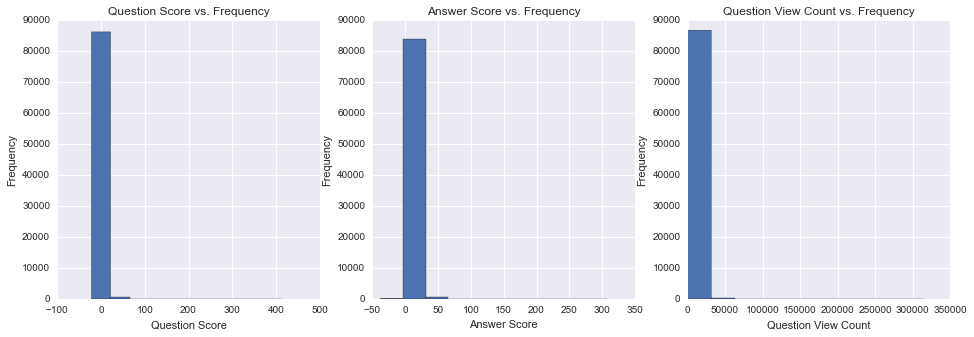

In [15]:
fig = plt.figure(figsize=(16, 5))
axis = fig.add_subplot(1, 3, 1)
plt.hist(question_scores)
plt.title('Question Score vs. Frequency')
plt.xlabel('Question Score')
plt.ylabel('Frequency')

axis = fig.add_subplot(1, 3, 2)
plt.hist(answer_scores)
plt.title('Answer Score vs. Frequency')
plt.xlabel('Answer Score')
plt.ylabel('Frequency')

axis = fig.add_subplot(1, 3, 3)
plt.hist(question_view_counts)
plt.title('Question View Count vs. Frequency')
plt.xlabel('Question View Count')
_ = plt.ylabel('Frequency')

Then, a simple function to aid with plotting features:

In [16]:
def plot_features(xs, ys, x_labels, y_labels):
    assert(len(xs) == len(ys) == len(x_labels) == len(y_labels))

    fig = plt.figure(figsize=(16, 5))
    for i, params in enumerate(zip(xs, ys, x_labels, y_labels)):
        # plot the graph
        x, y, x_label, y_label = params
        axis = fig.add_subplot(1, len(xs), i + 1)
        p = plt.scatter(x, y)
        
        # plot a linear fit line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line, = axis.plot(x, slope * np.array(x) + intercept, '-', color='green')
        
        # pretty it up
        plt.title(u'%s vs. %s (r² = %.3f)' % (y_label, x_label, r_value ** 2))
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    plt.show()

## Feature Plots
Now, it's finally time to start plotting.

### Question Favorite Count

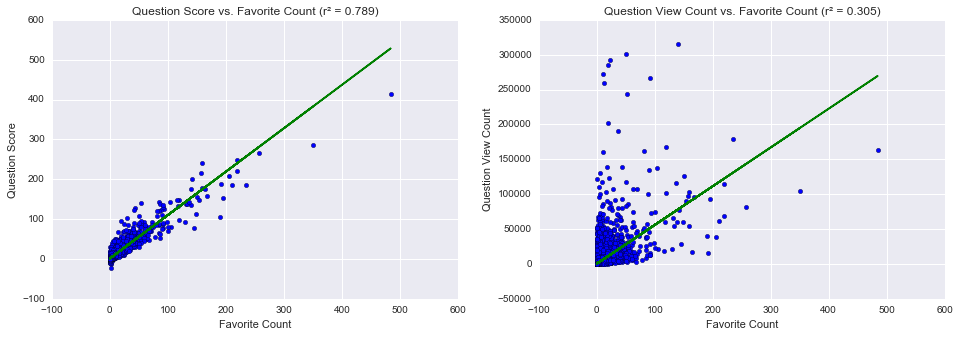

In [17]:
question_favorite_counts = query(c, '''
                                    SELECT FavoriteCount
                                    FROM posts
                                    WHERE PostTypeId = 1
                                    ORDER BY Id''')
question_favorite_counts = map(lambda x: x if x else 0, question_favorite_counts)

plot_features(
    [question_favorite_counts] * 2,
    ys_questions,
    ['Favorite Count'] * 2,
    y_labels_questions
)

Favorite count seems to be particularly useful in predicting question score and moderately useful when predicting view count.

### Post Body Length

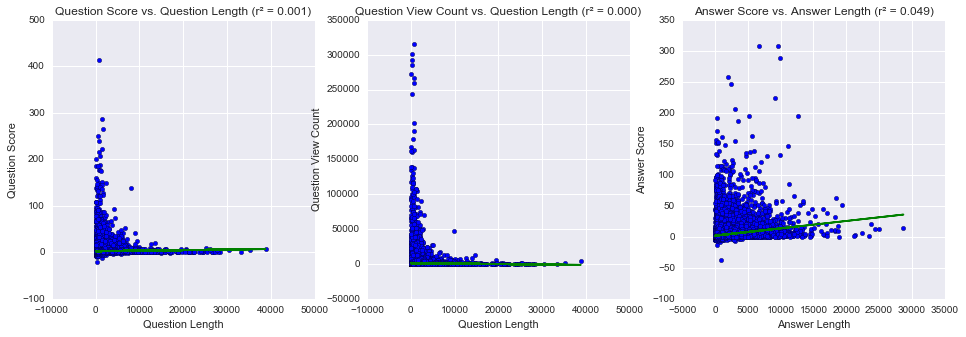

In [18]:
question_lengths = query(c, '''
                            SELECT LENGTH(Body)
                            FROM posts
                            WHERE PostTypeId = 1
                            ORDER BY Id ASC''')
answer_lengths = query(c, '''
                            SELECT LENGTH(Body)
                            FROM posts
                            WHERE PostTypeId = 2
                            ORDER BY Id ASC''')
plot_features(
    [question_lengths, question_lengths, answer_lengths], 
    ys,
    ['Question Length'] * 2 + ['Answer Length'], 
    y_labels
)

The length of a post appears only slighly helpful with predicting answer score.

### Question Title Length

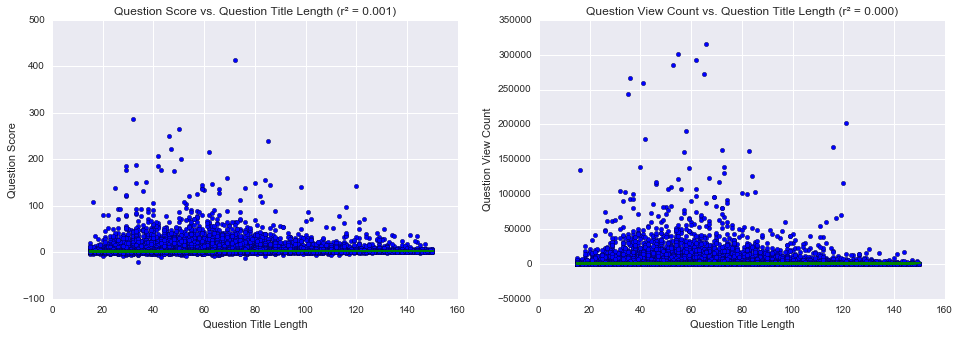

In [19]:
question_title_lengths = query(c, '''
                                    SELECT LENGTH(Title)
                                    FROM posts
                                    WHERE PostTypeId = 1
                                    ORDER BY Id''')
plot_features(
    [question_title_lengths] * 2,
    ys_questions,
    ['Question Title Length'] * 2,
    y_labels_questions
)

The title length of the question does not help much in predicting question score.

### Number of Question Tags

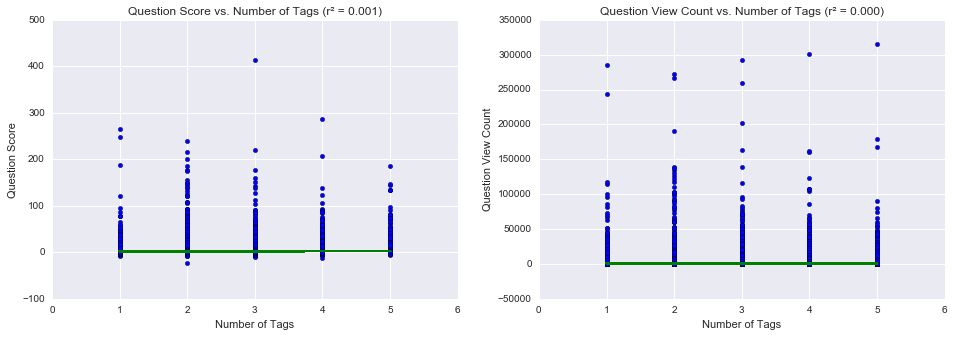

In [20]:
def get_tags(tag_string):
    tags = re.findall(r"<(.*?)>", tag_string)
    return tags

question_tags = query(c, '''
                        SELECT Tags
                        FROM posts
                        WHERE PostTypeId = 1
                        ORDER BY Id ASC''')
question_tags_list = map(lambda x: get_tags(x), question_tags)
question_tags_numbers = map(len, question_tags_list)

plot_features(
    [question_tags_numbers] * 2,
    ys_questions,
    ['Number of Tags'] * 2,
    y_labels_questions
)

The number of question tags does not seem to correlate with question score.

### Sum of Number of Questions under Question Tags

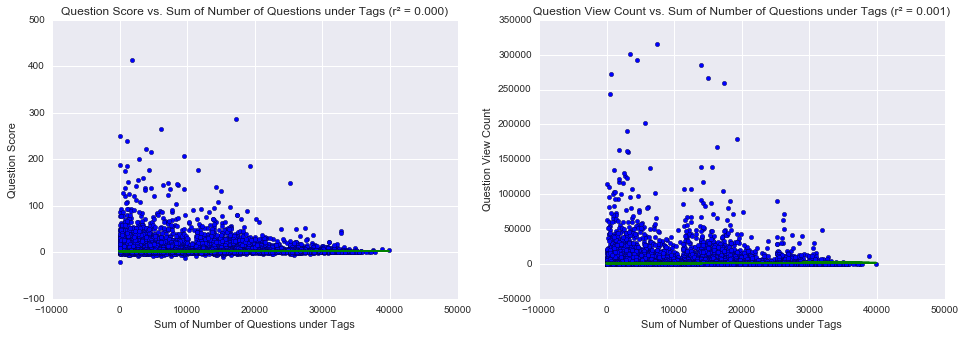

In [21]:
all_tags = c.execute('''
                        SELECT TagName, Count
                        FROM tags''').fetchall()
all_tags_dict = dict(all_tags)

question_sum_tags_count = map(lambda x: sum(map(lambda y: all_tags_dict[y], x)), question_tags_list)

plot_features(
    [question_sum_tags_count] * 2,
    ys_questions,
    ['Sum of Number of Questions under Tags'] * 2,
    y_labels_questions
)

We found little correlation between the question view count and sum of times each tag was used in a question.

### Post Author Reputation

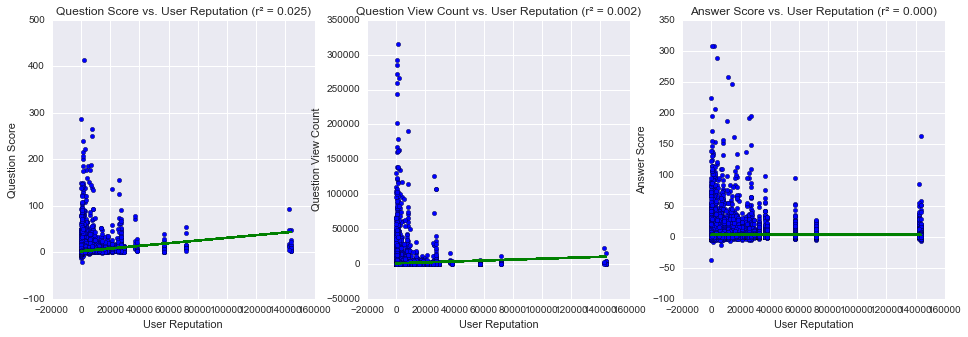

In [137]:
question_user_reputations = query(c, '''
                            SELECT users.Reputation
                            FROM posts
                            LEFT JOIN users ON posts.OwnerUserId = users.Id
                            WHERE posts.PostTypeId = 1
                            ORDER BY posts.Id''')

answer_user_reputations = query(c, '''
                            SELECT users.Reputation
                            FROM posts
                            LEFT JOIN users ON posts.OwnerUserId = users.Id
                            ORDER BY posts.Id''')

answer_user_reputations_filt, answer_scores_filt = \
            zip(*filter(lambda (x, _): x != None,
            zip(answer_user_reputations, answer_scores)))

plot_features(
    [question_user_reputations, question_user_reputations, answer_user_reputations_filt], 
    [question_scores, question_view_counts, answer_scores_filt],
    ['User Reputation'] * 3,
    y_labels
)

User reputation was slightly correlated with question score, but not nearly as much as anticipated. User reputation was much less correlated with question view counts and answer score.

### Question View Count

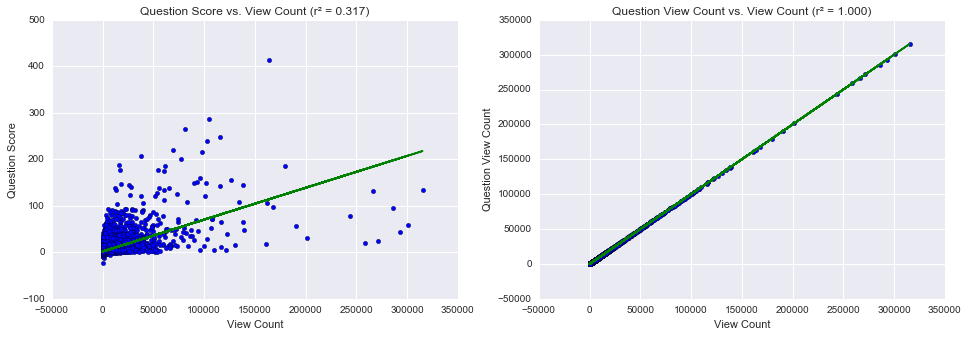

In [23]:
question_view_counts = query(c, '''
                            SELECT ViewCount
                            FROM posts
                            WHERE PostTypeId = 1
                            ORDER BY Id''')

plot_features(
    [question_view_counts] * 2,
    ys_questions,
    ['View Count'] * 2,
    y_labels_questions
)

View counts were moderately correlated with question score. By definition, view counts were highly correlated with themself.

### Question Time Since Posting

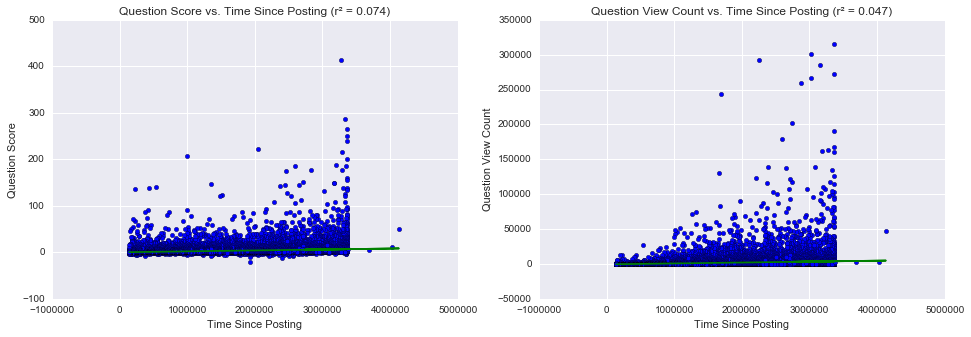

In [24]:
question_post_times = datetime_query(c, '''
                           SELECT CreationDate
                           FROM posts
                           WHERE PostTypeId = 1
                           ORDER BY Id''')

time_since_question_post = map(lambda x: (datetime.now() - x).total_seconds() / 60.0, question_post_times)

plot_features(
    [time_since_question_post] * 2,
    ys_questions,
    ['Time Since Posting'] * 2,
    y_labels_questions
)

### Time of Day

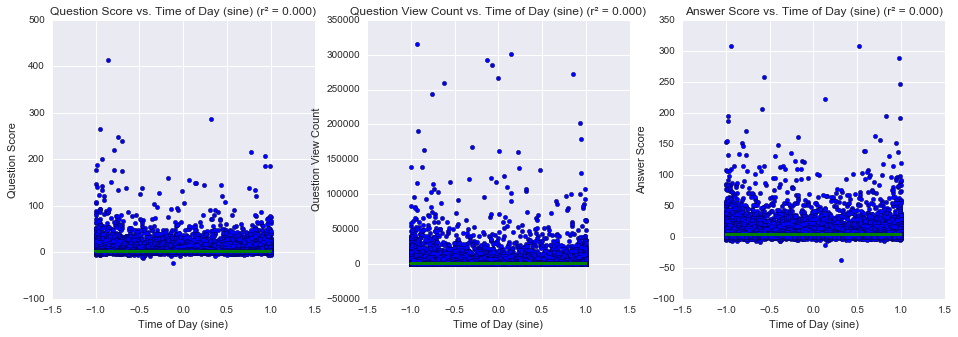

In [25]:
question_time_of_day = np.sin(map(lambda x: 2 * np.pi * (x.hour * 60 + x.minute) / (24 * 60), question_post_times))

answer_post_times = datetime_query(c, '''
                           SELECT CreationDate
                           FROM posts
                           WHERE PostTypeId = 2
                           ORDER BY Id''')
answer_time_of_day = np.sin(map(lambda x: 2 * np.pi * (x.hour * 60 + x.minute) / (24 * 60), answer_post_times))
    
plot_features(
    [question_time_of_day, question_time_of_day, answer_time_of_day],
    ys,
    ['Time of Day (sine)'] * 3,
    y_labels
)

### Comment Count

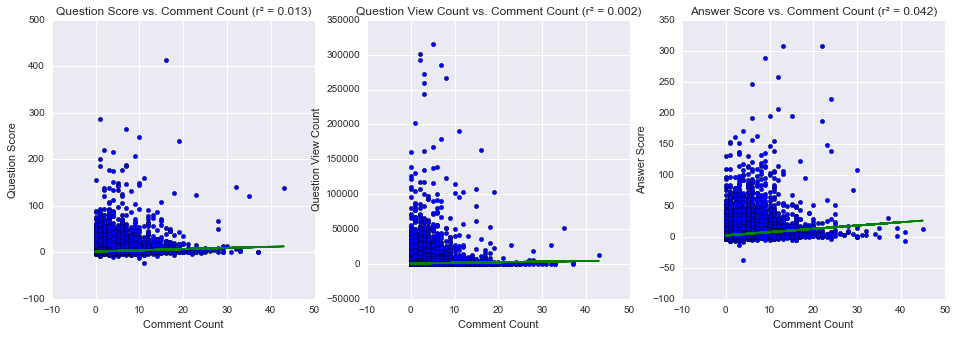

In [26]:
question_comment_count = query(c, '''
                            SELECT COUNT(comments.Id)
                            FROM posts
                            LEFT JOIN comments ON posts.Id = comments.PostId
                            WHERE posts.PostTypeId = 1
                            GROUP BY posts.Id
                            ORDER BY posts.Id''')

answer_comment_count = query(c, '''
                            SELECT COUNT(comments.Id)
                            FROM posts
                            LEFT JOIN comments ON posts.Id = comments.PostId
                            WHERE posts.PostTypeId = 2
                            GROUP BY posts.Id
                            ORDER BY posts.Id''')

plot_features(
    [question_comment_count, question_comment_count, answer_comment_count],
    ys,
    ['Comment Count'] * 3,
    y_labels
)

### Author Post Count

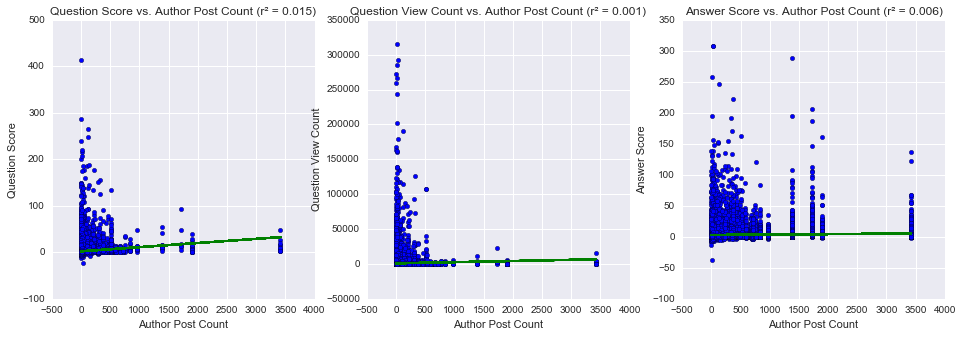

In [141]:
num_user_posts = c.execute('''
                            SELECT users.Id, COUNT(posts.Id)
                            FROM users
                            LEFT JOIN posts ON users.Id = posts.OwnerUserId
                            GROUP BY users.Id''').fetchall()
user_posts_dict = dict(num_user_posts)

question_user = query(c, '''
                            SELECT OwnerUserId
                            FROM posts
                            WHERE PostTypeId = 1
                            ORDER BY Id''')

answer_user = query(c, '''
                            SELECT OwnerUserId
                            FROM posts
                            WHERE PostTypeId = 2
                            ORDER BY Id''')

question_user_posts_count = map(user_posts_dict.__getitem__, question_user)
answer_user_posts_count = map(user_posts_dict.__getitem__, answer_user)

plot_features(
    [question_user_sum_posts] * 2 + [answer_user_posts_count],
    ys,
    ['Author Post Count'] * 3,
    y_labels
)

### Author Vote Count

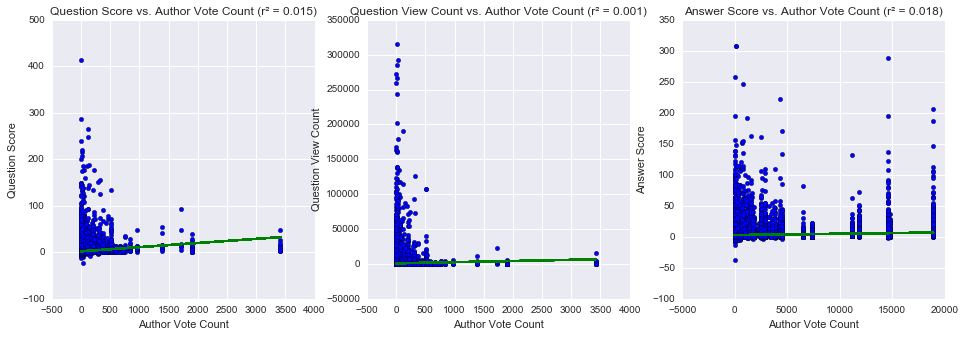

In [143]:
num_user_votes = c.execute('''
                            SELECT Id, UpVotes + DownVotes
                            FROM users
                            ''').fetchall()
user_votes_dict = dict(num_user_votes)

question_user_sum_votes = map(user_votes_dict.__getitem__, question_user) 
answer_user_sum_votes = map(user_votes_dict.__getitem__, answer_user) 

plot_features(
    [question_user_sum_posts] * 2 + [answer_user_sum_votes],
    ys,
    ['Author Vote Count'] * 3,
    y_labels
)

### Time Since Question Posting

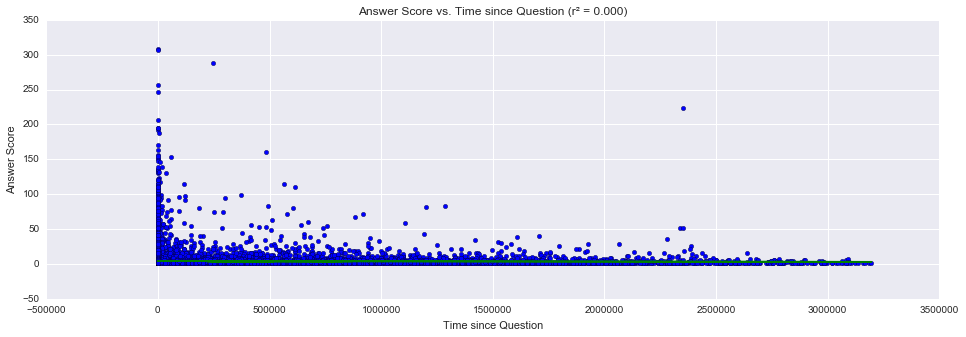

In [130]:
question_ids = query(c, '''
                        SELECT Id
                        FROM posts
                        WHERE PostTypeId = 1
                        ORDER BY Id''')

question_time_dict = dict(zip(question_ids, question_post_times))

answer_original_questions = query(c, '''
                                SELECT ParentId
                                FROM posts
                                WHERE PostTypeId = 2
                                ORDER BY Id''')

answer_original_question_time = map(lambda (answer_time, question_id):
                                    (answer_time - question_time_dict[question_id]).total_seconds() / 60.0,
                                    zip(answer_post_times, answer_original_questions))

answer_original_question_time_filt, answer_scores_filt = \
    zip(*filter(lambda (x, y): x > 0 and y > 0, zip(answer_original_question_time, answer_scores)))

plot_features(
    [answer_original_question_time_filt],
    [answer_scores_filt],
    ['Time since Question Posting'],
    y_labels_answers
)

### Answer Posting Order

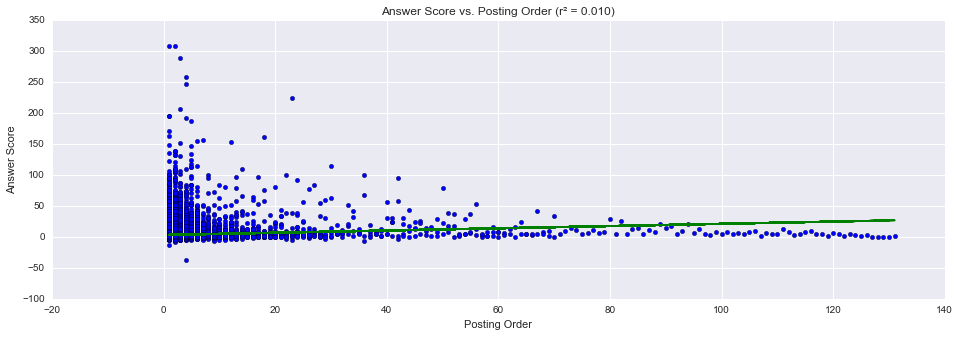

In [209]:
answer_original_questions_id = c.execute('''
                                    SELECT Id, ParentId
                                    FROM posts
                                    WHERE PostTypeId = 2
                                    ORDER BY Id''').fetchall()
answer_original_questions_id_time = map(lambda x: (x[0][0], x[0][1], x[1]), zip(answer_original_questions_id, answer_post_times))
answer_original_questions_id_time.sort(key=operator.itemgetter(1))
answer_groups = [(k, list(vs)) for k, vs in itertools.groupby(answer_original_questions_id_time, key=operator.itemgetter(1))]
answer_groups = map(lambda x: sorted(x[1], key=operator.itemgetter(2)), answer_groups)
answer_groups = map(lambda x: map(lambda y: (y[0] + 1, y[1][0]), enumerate(x)), answer_groups)
answers_flattened = list(itertools.chain.from_iterable(answer_groups))
answer_posting_order = list(map(operator.itemgetter(0), sorted(answers_flattened, key=operator.itemgetter(1))))
plot_features(
    [answer_posting_order],
    [answer_scores],
    ['Posting Order'],
    y_labels_answers
)